In [2]:
#complete post processing: loss functions, test samples and statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import os

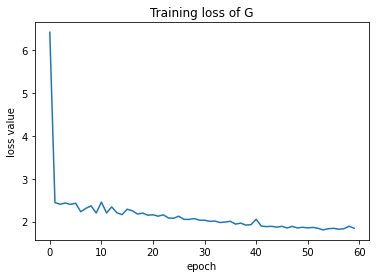

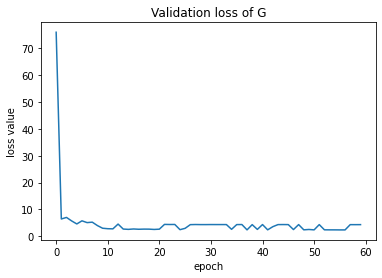

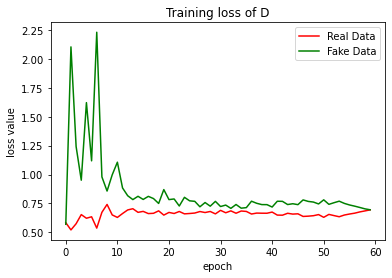

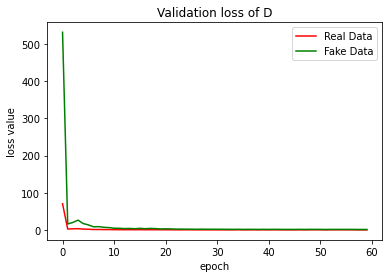

In [8]:
#plot the loss functions

#separate
common_dir='/vol/calvin/data/dbhatnagar/July23/PlotsJuly19/'
gen_loss_tr=np.load(common_dir +'train_loss_G.npy')
plt.plot(gen_loss_tr)
plt.title('Training loss of G')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

gen_loss_val=np.load(common_dir +'val_loss_G.npy')
plt.plot(gen_loss_val)
plt.title('Validation loss of G')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

disc_loss_real_tr=np.load(common_dir +'train_loss_D_real.npy')
disc_loss_fake_tr=np.load(common_dir +'train_loss_D_fake.npy')
plt.plot(disc_loss_real_tr,'r',label="Real Data")
plt.plot(disc_loss_fake_tr,'g',label="Fake Data")
plt.title('Training loss of D')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

disc_loss_real_val=np.load(common_dir +'val_loss_D_real.npy')
disc_loss_fake_val=np.load(common_dir +'val_loss_D_fake.npy')
plt.plot(disc_loss_real_val,'r',label="Real Data")
plt.plot(disc_loss_fake_val,'g',label="Fake Data")
plt.title('Validation loss of D')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

In [6]:
#loads a model 

def cnn_block(in_channels,out_channels,kernel_size,stride,padding, first_layer = False):

   if first_layer:
       return nn.Conv3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)
   else:
       return nn.Sequential(
           nn.Conv3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
           nn.BatchNorm3d(out_channels,momentum=0.1,eps=1e-5),
           )

def tcnn_block(in_channels,out_channels,kernel_size,stride,padding,output_padding=0, first_layer = False):
   if first_layer:
       return nn.ConvTranspose3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding)

   else:
       return nn.Sequential(
           nn.ConvTranspose3d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding),
           nn.BatchNorm3d(out_channels,momentum=0.1,eps=1e-5),
           )
   
#parameters

gf_dim = 64
df_dim = 64
in_w = in_h = in_d = 128 #dimensions of a single data sample
c_dim = 1 #color channels, 1 for grayscale

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#generator

class Generator(nn.Module):
 def __init__(self,instance_norm=False):#input : 1 x 128^3
   super(Generator,self).__init__()
   self.e1 = cnn_block(c_dim,gf_dim,4,2,1, first_layer = True) #64 x 64^3
   self.e2 = cnn_block(gf_dim,gf_dim*2,4,2,1) #128 x 32^3
   self.e3 = cnn_block(gf_dim*2,gf_dim*4,4,2,1) #256 x 16^3
   self.e4 = cnn_block(gf_dim*4,gf_dim*8,4,2,1) #512 x 8^3
   self.e5 = cnn_block(gf_dim*8,gf_dim*8,4,2,1) #512 x 4^3
   self.e6 = cnn_block(gf_dim*8,gf_dim*8,4,2,1) #512 x 2^3
   self.e7 = cnn_block(gf_dim*8,gf_dim*8,4,2,1,first_layer=True) #512 x 1^3 #bottleneck

   self.d1 = tcnn_block(gf_dim*8,gf_dim*8,4,2,1) # 512 x 2^3
   self.d2 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1) #512 x 4^3
   self.d3 = tcnn_block(gf_dim*8*2,gf_dim*8,4,2,1) #512 x 8^3
   self.d4 = tcnn_block(gf_dim*8*2,gf_dim*4,4,2,1) #256 x 16^3
   self.d5 = tcnn_block(gf_dim*4*2,gf_dim*2,4,2,1) #128 x 32^3
   self.d6 = tcnn_block(gf_dim*2*2,gf_dim*1,4,2,1) #64 x 64^3
   self.d7 = tcnn_block(gf_dim*1*2,c_dim,4,2,1, first_layer = True)#1 x 128^3
   self.tanh = nn.Tanh()

 def forward(self,x):
   e1 = self.e1(x)
   #print(e1.shape,"e1")
   e2 = self.e2(F.leaky_relu(e1,0.2))
   #print(e2.shape,"e2")
   e3 = self.e3(F.leaky_relu(e2,0.2))
   #print(e3.shape,"e3")
   e4 = self.e4(F.leaky_relu(e3,0.2))
   #print(e4.shape,"e4")
   e5 = self.e5(F.leaky_relu(e4,0.2))
   #print(e5.shape,"e5")
   e6 = self.e6(F.leaky_relu(e5,0.2))
   #print(e6.shape,"e6")
   e7 = self.e7(F.leaky_relu(e6,0.2))
   #print(e7.shape,"e7")
   #e7 = self.e7(F.leaky_relu(e6,0.2))
   #e8 = self.e8(F.leaky_relu(e7,0.2))
   #d0=self.d0(e6)
   #print(d0.shape,"d0")
   d1 = torch.cat([F.dropout(self.d1(F.relu(e7)),0.5,training=True),e6],1)
   #print(d1.shape,"d1")
   d2 = torch.cat([F.dropout(self.d2(F.relu(d1)),0.5,training=True),e5],1)
   #print(d2.shape,"d2")
   d3 = torch.cat([F.dropout(self.d3(F.relu(d2)),0.5,training=True),e4],1)
   #print(d3.shape,"d3")
   d4 = torch.cat([self.d4(F.relu(d3)),e3],1)
   #print(d4.shape,"d4")
   d5 = torch.cat([self.d5(F.relu(d4)),e2],1)
   #print(d5.shape,"d5")
   d6 = torch.cat([self.d6(F.relu(d5)),e1],1)
   #print(d6.shape,"d6")
   d7 = self.d7(F.relu(d6))
   #print(d7.shape,"d7")


   return self.tanh(d7)



def test():
  x=torch.randn((1,1,128,128,128))
  model=Generator()
  preds=model(x)
  print(preds.shape)

#test()




In [9]:
#Select your mode
option=['IF','FF']
option1=['IN','FI']
opt_val=0 # 0 for I to F and 1 for F to I
selected=option[opt_val]
selected1=option1[opt_val]


In [7]:
generator_loaded = Generator().to(device)  # create an instance of the generator model
generator_loaded.load_state_dict(torch.load(f'/vol/calvin/data/dbhatnagar/Results_Summary/Vbestmodel_Gen_{selected}.pth',map_location=torch.device('cpu')))# load the saved model parameters
generator_loaded.eval()

Generator(
  (e1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (e2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e4): Sequential(
    (0): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e5): Sequential(
    (0): Conv3d(512, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (e6): Sequential(
    (0): Conv3d(512, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  

In [4]:
#transformations
def log_transform(arr):
    a=4
    # Create a copy of the original array
    transformed_arr = np.copy(arr)
    
    # DISABLE IN FUTURE
    transformed_arr += abs(np.min(transformed_arr)) + 1e-9 
    
    # Apply the transformation equation to the array
    transformed_arr = (2 * transformed_arr / (transformed_arr + a)) - 1
    
    return transformed_arr

def log10_transform(arr):
  OG_arr=np.copy(arr)
  OG_arr=OG_arr + 1
  return np.log10(OG_arr)

def inverse_log_transform(arr):
  a=4
  # Create a copy of the original array
  in_transformed_arr = np.copy(arr)
  # Apply the in transformation equation to the array
  in_transformed_arr = (a * (1 + in_transformed_arr))/(1 -in_transformed_arr)
  return in_transformed_arr


In [5]:
#TestSet



t_i=7000
t_f=7010

def loads_arrays(in_val,fin_val,in_=True):
    loaded_array=[]
    loaded_list=[]
    for i in range(in_val,fin_val):
        k=i+1
        if in_==True:
            loaded_array=np.load('/vol/calvin/data/dbhatnagar/IF_128/IN_File_128_{0}.npy'.format(k))
            loaded_list.append(loaded_array)

        else:
            loaded_array=np.load('/vol/calvin/data/dbhatnagar/FF_128/FI_File_128_{0}.npy'.format(k))
            loaded_list.append(loaded_array)

    return loaded_list


INITIAL_TEST=loads_arrays(t_i,t_f,in_=True)
FINAL_TEST=loads_arrays(t_i,t_f,in_=False)

-0.9611837 vmin
0.15286675 vmax


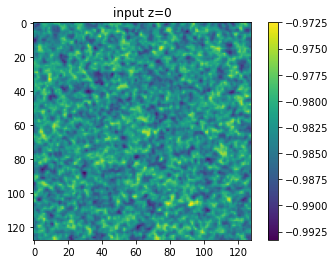

<Figure size 432x288 with 0 Axes>

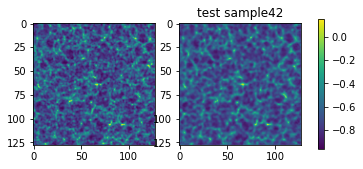

Correlation coefficient: 0.781120033960759


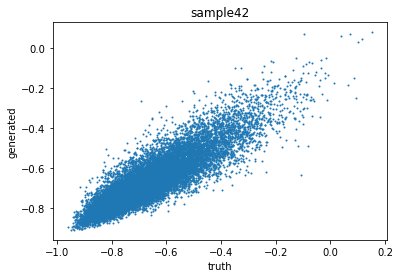

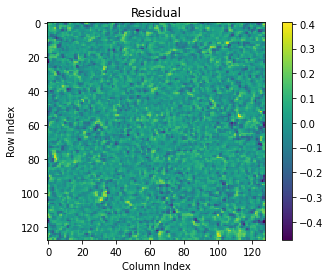

In [22]:
#select your mode, gives 5 random test samples along with statistics  
#no need to load model here 
#everything is already log transformed as per the trained model

#plots of samples
test_length=1 #number of test samples wanted
dir=['I_F_192epoch/test_July5_B','F_I_120epoch']
present_dir=f'/vol/calvin/data/dbhatnagar/Results_Summary/{dir[opt_val]}/'
#present_dir='/vol/calvin/data/dbhatnagar/Results_Summary/F_I_45epoch/'
for i in range(0,test_length):
    p=random_int = np.random.randint(1, 100)
    data1=np.load(present_dir + f'ground_truth{p}.npy')  #truth NO need log trans 
    data2=np.load(present_dir +  f'generated_sample{p}.npy')  #generated: NO need log trans

    if opt_val==0: 
        data3=np.load(present_dir + f'initial_sample{p}.npy') #initial or final: already log transformed
    else:
       data3=np.load(present_dir + f'final_sample{p}.npy') #initial or final: already log transformed
    

# for delta 
    # data1=inverse_log_transform(data1) 
    # data2=inverse_log_transform(data2)
#for log10+1 delta
    # data1=inverse_log_transform(data1) 
    # data2=inverse_log_transform(data2)
    # data1=log10_transform(data1)
    # data2=log10_transform(data2)

    data1=data1.squeeze(0)
    data1=data1.squeeze(0)
    data3=data3.squeeze(0)
    data3=data3.squeeze(0)
    #data2 is already 128 x 128 x128
    
    data1 = np.mean(data1[:,:,0:4], axis=2)
    data2 = np.mean(data2[:,:,0:4], axis=2)
    data3 = np.mean(data3[:,:,0:4], axis=2)
    if i==0:
        vmin = min(np.min(data1), np.min(data2))
        vmax = max(np.max(data1), np.max(data2))
        print(vmin,'vmin')
        print(vmax,'vmax')


    # Plot the third data
    #plt.figure()



    #im3 = ax3.imshow(data3, cmap='viridis')
    #cbar = fig.colorbar(im3, shrink=0.6)
    plt.imshow(data3,'viridis')
    plt.colorbar()
    z=['127','0']
    plt.title(f'input z={opt_val}')
    plt.figure()

    #plot on same color bar
    fig, (ax1, ax2) = plt.subplots(1, 2)
   

# Plot the first data
    im1 = ax1.imshow(data1, cmap='viridis',vmin=vmin,vmax=vmax)
    

# Plot the second data
    im2 = ax2.imshow(data2, cmap='viridis',vmin=vmin,vmax=vmax)

    
    

# Create a common colorbar
    cbar = fig.colorbar(im2,ax=[ax1, ax2], shrink=0.6)
    plt.title(f'test sample{p}')

# Display the plots
    #plt.imshow(vmin=vmin_,vmax=vmax_)
    plt.show()
    plt.figure()

    plt.scatter(data1, data2,s=1)
    correlation_coefficient = np.corrcoef(data1, data2)[0, 1]

# Print the correlation coefficient
    print("Correlation coefficient:", correlation_coefficient)
    

# Set axis labels
    plt.xlabel('truth')
    plt.ylabel('generated')
    plt.title(f'sample{p}')
    plt.figure()
    plt.imshow(sub, cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title("Residual")
  
    plt.show()



In [ ]:
#uses the loaded model and computes statistics over 1000 test samples